In [1]:
import os
import time
import shutil
import tarfile
import pathlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import seaborn as sns
import xgboost as xgb 
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, r2_score
from sklearn.linear_model import Lasso, LassoCV, MultiTaskLassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import optimizers
from keras.initializers import lecun_normal
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [2]:
tf.__version__

'2.0.0'

In [3]:
PATH_INPUT_TABLE = '[i] data/'

In [4]:
if not(os.path.isdir(PATH_INPUT_TABLE)):
    os.makedirs(PATH_INPUT_TABLE)

In [5]:
# CSV TO DATA
def csvToData(csv_file):
    df = pd.read_csv(csv_file, header = 0)
    column = list(df.columns.values)
    data = df.values
    return column, data

sample_column, sample_csv_data = csvToData(PATH_INPUT_TABLE+"sample_submission.csv")
test_column, test_csv_data = csvToData(PATH_INPUT_TABLE+"test.csv")
train_column, train_csv_data = csvToData(PATH_INPUT_TABLE+"train.csv")
print('sample_submission-----------')
print(sample_column)
print(sample_csv_data.shape)
print('test-----------')
print(test_column)
print(test_csv_data.shape)
print('train-----------')
print(train_column)
print(train_csv_data.shape)


sample_submission-----------
['id', 'hhb', 'hbo2', 'ca', 'na']
(10000, 5)
test-----------
['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_src', '730_src', '740_src', '750_src', '760_src', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src', '830_src', '840_src', '850_src', '860_src', '870_src', '880_src', '890_src', '900_src', '910_src', '920_src', '930_src', '940_src', '950_src', '960_src', '970_src', '980_src', '990_src', '650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst', '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']
(10000, 72)
train-----------
['id', 'rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_s

In [6]:
# Data to DataFrame
sample_data = pd.DataFrame(sample_csv_data, columns=sample_column)
test_data = pd.DataFrame(test_csv_data, columns=test_column)
train_data = pd.DataFrame(train_csv_data, columns=train_column)
print(sample_data.shape, test_data.shape, train_data.shape)

(10000, 5) (10000, 72) (10000, 76)


In [7]:
src_list=['650_src', '660_src', '670_src', '680_src', '690_src', '700_src', '710_src', '720_src', '730_src', 
          '740_src', '750_src', '760_src', '770_src', '780_src', '790_src', '800_src', '810_src', '820_src', 
          '830_src', '840_src', '850_src', '860_src', '870_src', '880_src', '890_src', '900_src', '910_src', 
          '920_src', '930_src', '940_src', '950_src', '960_src', '970_src', '980_src', '990_src']
dst_list=['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst', '710_dst', '720_dst', '730_dst', 
          '740_dst', '750_dst', '760_dst', '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst', 
          '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst', '890_dst', '900_dst', '910_dst', 
          '920_dst', '930_dst', '940_dst', '950_dst', '960_dst', '970_dst', '980_dst', '990_dst']

In [8]:
# 보간법 tqdm , 
from tqdm import tqdm
alpha=train_data[dst_list]
beta=test_data[dst_list]

for i in tqdm(train_data.index):
    alpha.loc[i] = alpha.loc[i].interpolate()
    
for i in tqdm(test_data.index):
    beta.loc[i] = beta.loc[i].interpolate()
    
#위에 보간법을 사용하게되면, 앞단에 비는 경우가 발생. 빌 경우 뒷단에 있는 데이터를 끌어다가 씀.
alpha.loc[alpha['700_dst'].isnull(),'700_dst']=alpha.loc[alpha['700_dst'].isnull(),'710_dst']
alpha.loc[alpha['690_dst'].isnull(),'690_dst']=alpha.loc[alpha['690_dst'].isnull(),'700_dst']
alpha.loc[alpha['680_dst'].isnull(),'680_dst']=alpha.loc[alpha['680_dst'].isnull(),'690_dst']
alpha.loc[alpha['670_dst'].isnull(),'670_dst']=alpha.loc[alpha['670_dst'].isnull(),'680_dst']
alpha.loc[alpha['660_dst'].isnull(),'660_dst']=alpha.loc[alpha['660_dst'].isnull(),'670_dst']
alpha.loc[alpha['650_dst'].isnull(),'650_dst']=alpha.loc[alpha['650_dst'].isnull(),'660_dst']

beta.loc[beta['700_dst'].isnull(),'700_dst']=beta.loc[beta['700_dst'].isnull(),'710_dst']
beta.loc[beta['690_dst'].isnull(),'690_dst']=beta.loc[beta['690_dst'].isnull(),'700_dst']
beta.loc[beta['680_dst'].isnull(),'680_dst']=beta.loc[beta['680_dst'].isnull(),'690_dst']
beta.loc[beta['670_dst'].isnull(),'670_dst']=beta.loc[beta['670_dst'].isnull(),'680_dst']
beta.loc[beta['660_dst'].isnull(),'660_dst']=beta.loc[beta['660_dst'].isnull(),'670_dst']
beta.loc[beta['650_dst'].isnull(),'650_dst']=beta.loc[beta['650_dst'].isnull(),'660_dst']

train_data[dst_list] = np.array(alpha)
test_data[dst_list] = np.array(beta)

100%|██████████| 10000/10000 [00:11<00:00, 846.10it/s]


In [9]:
# rho 값의 제곱을 dst에 곱해줌.
for col in dst_list:
    train_data[col] = train_data[col] * (train_data['rho'] ** 2)
    test_data[col] = test_data[col] * (test_data['rho']**2)

In [10]:
# rho 값을 범주형 변수로 가정하고 원-핫-인코딩 적용 (JYH)
train_data[['rho_10', 'rho_15', 'rho_20', 'rho_25']] = pd.get_dummies(train_data['rho'])
test_data[['rho_10', 'rho_15', 'rho_20', 'rho_25']] = pd.get_dummies(test_data['rho'])

In [11]:
#원래 빛과 측정빛의 차이값을 변수로 추가
gap_feature_names=[]
for i in range(650, 1000, 10):
    gap_feature_names.append(str(i) + '_gap')

alpha=pd.DataFrame(np.array(train_data[src_list]) - np.array(train_data[dst_list]), columns=gap_feature_names, index=train_data.index)
beta=pd.DataFrame(np.array(test_data[src_list]) - np.array(test_data[dst_list]), columns=gap_feature_names, index=test_data.index)

train_data=pd.concat((train_data, alpha), axis=1)
test_data=pd.concat((test_data, beta), axis=1)

In [12]:
#원래 빛과 측정빛의 차이 비율을 변수 추가
epsilon=1e-10

for dst_col, src_col in zip(dst_list, src_list):
    dst_val=train_data[dst_col]
    src_val=train_data[src_col] + epsilon
    
    delta_ratio = dst_val / src_val
    train_data[dst_col + '_' + src_col + '_ratio'] = delta_ratio
    
    dst_val=test_data[dst_col]
    src_val=test_data[src_col] + epsilon
    
    delta_ratio = dst_val / src_val
    test_data[dst_col + '_' + src_col + '_ratio'] = delta_ratio

In [13]:
##측정 빛에 이산 푸리에 변환
alpha_real=train_data[dst_list]
alpha_imag=train_data[dst_list]

beta_real=test_data[dst_list]
beta_imag=test_data[dst_list]

for i in tqdm(alpha_real.index):
    alpha_real.loc[i]=alpha_real.loc[i] - alpha_real.loc[i].mean()
    alpha_imag.loc[i]=alpha_imag.loc[i] - alpha_real.loc[i].mean()
    
    alpha_real.loc[i] = np.fft.fft(alpha_real.loc[i], norm='ortho').real
    alpha_imag.loc[i] = np.fft.fft(alpha_imag.loc[i], norm='ortho').imag

    
for i in tqdm(beta_real.index):
    beta_real.loc[i]=beta_real.loc[i] - beta_real.loc[i].mean()
    beta_imag.loc[i]=beta_imag.loc[i] - beta_imag.loc[i].mean()
    
    beta_real.loc[i] = np.fft.fft(beta_real.loc[i], norm='ortho').real
    beta_imag.loc[i] = np.fft.fft(beta_imag.loc[i], norm='ortho').imag
    
real_part=[]
imag_part=[]

for col in dst_list:
    real_part.append(col + '_fft_real')
    imag_part.append(col + '_fft_imag')
    
alpha_real.columns=real_part
alpha_imag.columns=imag_part
alpha = pd.concat((alpha_real, alpha_imag), axis=1)

beta_real.columns=real_part
beta_imag.columns=imag_part
beta=pd.concat((beta_real, beta_imag), axis=1)

train_data=pd.concat((train_data, alpha), axis=1)
test_data=pd.concat((test_data, beta), axis=1)

100%|██████████| 10000/10000 [00:27<00:00, 361.25it/s]


In [14]:
print(np.isnan(train_data).values.any(),np.isnan(test_data).values.any())

False False


## Data split

training data ( 8000개 ) = train_dataset

validataion data ( 2000개 ) = test_dataset

In [15]:
num_traindata = 8000
num_validdata = 2000
from sklearn.utils import shuffle
#train_data = shuffle(train_data) # 여기서 섞지 않고 뒤에서 섞음
train_dataset = train_data[:num_traindata]
valid_dataset = train_data[num_traindata : num_traindata + num_validdata]
train_dataset = train_dataset.drop('id',axis = 1)
valid_dataset = valid_dataset.drop('id',axis = 1)
print(train_dataset.shape, valid_dataset.shape)

(8000, 219) (2000, 219)


In [16]:
train_data

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst_fft_imag,910_dst_fft_imag,920_dst_fft_imag,930_dst_fft_imag,940_dst_fft_imag,950_dst_fft_imag,960_dst_fft_imag,970_dst_fft_imag,980_dst_fft_imag,990_dst_fft_imag
0,0.0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,-2.499150e-15,-5.925972e-15,-5.878608e-15,-1.828763e-15,-1.414001e-14,8.639731e-15,-2.049048e-14,1.885808e-14,-1.766556e-14,9.777743e-15
1,1.0,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.226312e-07,2.042524e-09,-1.725298e-07,-4.027819e-07,-4.362750e-07,-1.309430e-07,4.438995e-08,-6.220824e-08,-6.684540e-07,-8.733176e-07
2,2.0,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,-1.244490e-15,1.132792e-15,-9.380224e-16,8.110310e-17,1.436967e-16,-6.232595e-16,-1.244170e-15,1.100232e-15,3.127724e-17,-7.971691e-16
3,3.0,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,1.093222e-09,-4.249315e-09,1.830984e-09,-1.644763e-08,-2.100219e-08,2.896683e-08,-6.658898e-08,5.905257e-08,-8.667646e-08,3.411591e-08
4,4.0,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,-2.365378e-12,-1.182417e-11,4.492002e-12,-7.566927e-12,-1.531614e-11,2.051367e-11,-2.805906e-11,4.161645e-12,-2.011835e-11,-1.183212e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995.0,15.0,0.23929,0.30265,0.39929,0.51000,0.64072,0.77328,0.86722,0.95891,...,-7.647036e-13,-2.248163e-12,-1.287705e-12,2.257995e-12,-7.975467e-12,4.008263e-12,-1.117272e-11,9.489414e-12,-9.229368e-12,1.198400e-11
9996,9996.0,20.0,0.02583,0.00946,0.03650,0.01380,0.04093,0.04363,0.03260,0.05282,...,-2.313764e-13,-2.243088e-13,-3.746210e-13,-1.705076e-13,-3.617507e-13,-2.187408e-13,-2.045813e-13,-3.027191e-13,-2.102738e-14,-2.125466e-13
9997,9997.0,10.0,0.57589,0.62976,0.70571,0.77248,0.85402,0.92796,0.97691,0.98933,...,-5.704373e-09,-6.291574e-09,-4.768703e-09,-7.104155e-09,-1.363704e-08,2.921666e-09,-2.069228e-08,9.994165e-09,-1.584549e-08,-2.666935e-09
9998,9998.0,15.0,1.01477,1.01504,0.99125,0.98747,1.00717,1.01434,0.99529,1.01322,...,-3.517399e-10,-4.924663e-10,-5.726573e-10,-4.265951e-10,-7.675309e-10,-2.876941e-10,-7.593025e-10,-1.649193e-10,-4.454471e-10,-1.178532e-10


## Data split

--training data ( 8000 )

x_train

y_train

--validation data ( 2000 )

x_test

y_test

--training data ( 10000 )

x_train_sample 

y_train_sample

In [17]:
train_dataset.keys()

Index(['rho', '650_src', '660_src', '670_src', '680_src', '690_src', '700_src',
       '710_src', '720_src', '730_src',
       ...
       '900_dst_fft_imag', '910_dst_fft_imag', '920_dst_fft_imag',
       '930_dst_fft_imag', '940_dst_fft_imag', '950_dst_fft_imag',
       '960_dst_fft_imag', '970_dst_fft_imag', '980_dst_fft_imag',
       '990_dst_fft_imag'],
      dtype='object', length=219)

In [18]:
#x_train, y_train 분류
x_train = train_dataset.loc[:, 'rho':] # train dataset
x_train.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train = train_dataset.loc[:, 'hhb':'na'] # train labels
x_train.shape, y_train.shape

((8000, 215), (8000, 4))

In [19]:
#x_test, y_test 분류
x_test = valid_dataset.loc[:, 'rho':] # test dataset
x_test.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_test = valid_dataset.loc[:, 'hhb':'na'] # test labels
x_test.shape, y_test.shape

((2000, 215), (2000, 4))

In [20]:
#sample Code 용
#x_train_sample = train_data.loc[:, 'rho':] # train dataset
x_train_sample = train_data.loc[:, '650_src':] # train dataset
x_train_sample.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
y_train_sample = train_data.loc[:, 'hhb':'na'] # train labels
x_train_sample.shape, y_train_sample.shape

((10000, 214), (10000, 4))

In [21]:
#sample Code 용
#x_train_sample = train_data.loc[:, 'rho':] # test dataset
x_test_sample = test_data.loc[:, '650_src':] # test dataset
#x_test_sample.drop(['hhb','hbo2','ca','na'], axis='columns', inplace=True)
#y_test_sample = test_data.loc[:, 'hhb':'na'] # train labels
x_test_sample.shape#, y_test_sample.shape

(10000, 214)

In [22]:
import copy

In [23]:
# train, validation, test 분할 (JYH)
# 교차 검증을 할 것이므로 train, test 로만 분할
X = copy.deepcopy(x_train_sample) # 단순 대입을 하면 참조가 됨. 값을 복사
Y = copy.deepcopy(y_train_sample) # 단순 대입을 하면 참조가 됨. 값을 복사

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [24]:
# 제출용. DataFrame 형식으로 변환
x_submit_df = pd.DataFrame(x_test_sample, columns=x_train.columns)

In [25]:
# Scaler (JYH)
from sklearn.preprocessing import MinMaxScaler

#x_train_scaled = {}
#x_test_scaled = {}
#x_submit_scaled = {}
scalers = list()
#for col in y_train_sample.columns:
scaler = MinMaxScaler()
scaler.fit(x_train)
scalers.append(scaler)

x_train_scaled = pd.DataFrame(scaler.transform(x_train), index=x_train.index, columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), index=x_test.index, columns=x_test.columns)
x_submit_scaled = pd.DataFrame(scaler.transform(x_submit_df), index=x_submit_df.index, columns=x_submit_df.columns)

hhb (8000, 214) (8000, 150) (2000, 214) (2000, 150)
hbo2 (8000, 214) (8000, 150) (2000, 214) (2000, 150)
ca (8000, 214) (8000, 150) (2000, 214) (2000, 150)
na (8000, 214) (8000, 150) (2000, 214) (2000, 150)


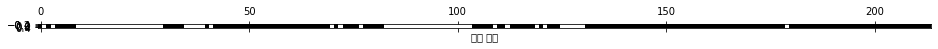

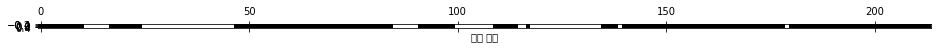

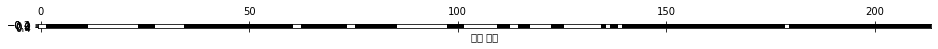

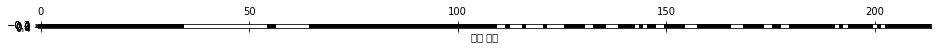

In [26]:
# 특성 선택 (일변량 통계)(특성 공학) (JYH)
from sklearn.feature_selection import SelectPercentile

select = SelectPercentile(percentile=70)

x_train_selected = {}
x_test_selected = {}
x_submit_selected = {}

for col in y_train_sample.columns:
    select.fit(x_train_scaled, y_train[col])
    np_selected = select.transform(x_train_scaled)
    mask = select.get_support()
    
    x_train_selected[col] = pd.DataFrame(np_selected, columns=x_train.columns[mask])
    x_test_selected[col] = pd.DataFrame(x_test_scaled, columns=x_train.columns[mask])[x_train_scaled.columns[mask]]
    x_submit_selected[col] = pd.DataFrame(x_submit_scaled[x_train.columns[mask]], columns=x_train.columns[mask])
    
    print(col, x_train_scaled.shape, x_train_selected[col].shape, x_test_scaled.shape, x_test_selected[col].shape)
    plt.matshow(mask.reshape(1,-1), cmap='gray_r')
    plt.xlabel('특성 번호')

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import time
#from sklearn.cross_validation import kFold

In [28]:
# https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

def FitModel(x_data, y_data):
    """
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0) 
    param_dis = {'n_estimators': stats.randint(80, 500),
                 'learning_rate': stats.uniform(0.01, 0.6),
                 'subsample': stats.uniform(0.3, 0.9),
                 'max_depth': [3, 4, 5, 6, 7, 8, 9],
                 'colsample_bytree': stats.uniform(0.5, 0.9),
                 'min_child_weight': [1, 2, 3, 4]}
    """
    """
    xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, colsample_bytree=1, gamma=0,
           importance_type='gain', learning_rate=0.1, max_delta_step=0,
           max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
           #n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
           n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
           silent=None, subsample=1, verbosity=1)
    """
    
    #score = xgbr.score(x_data, y_data)
    #print("training score", score)
    
    #kfold = KFold(n_splits=5, shuffle=True)
    #scores = cross_val_score(xgbr, x_data, y_data, cv=kfold)
    #print("K-fold CV average score: %.2f" % scores.mean())
    
    clf = xgb.XGBRegressor(
        eval_metric = 'rmse',
        nthread = 4,
        eta = 0.1,
        num_boost_round = 80,
        max_depth = 5,
        subsample = 0.5,
        colsample_bytree = 1.0,
        silent = 1,
        )
    parameters = {
        'num_boost_round': [10, 25, 50],
        'eta': [0.05, 0.1, 0.3],
        'max_depth': [3, 4, 5],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
    }
    clf1 = RandomizedSearchCV(clf, parameters, n_jobs=1, cv=2)
    print(clf1)
    
    start = time.time()
    clf1.fit(x_data, y_data)
    #best_parameters, score, _ = max(clf1.grid_scores_, key=lambda x: x[1])
    #print('RandomizedSearchCV Results: ', score)
    print(clf1.best_params_)
    
    score = clf1.score(x_data, y_data)
    print("training score", score)
    
    kfold = KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(clf1, x_data, y_data, cv=kfold)
    print("K-fold CV average score: %.2f" % scores.mean())
    
    #for param_name in sorted(best_parameters.keys()):
    #    print("%s: %r" % (param_name, best_parameters[param_name]))
    end = time.time()
    print('time elapsed: ' + str(end-start))
    #y_predict2 = clf2.predict(x_test)
    
    return clf1
    
models = {}
for label in y_train.columns:
    print(label)
    #models[label] = FitModel(x_train_selected[label], y_train_sample[label])
    models[label] = FitModel(x_train_selected[label], y_train[label])

hhb
RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1.0, eta=0.1,
                                          eval_metric='rmse', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=5,
                                          min_child_weight=None, missing=nan,
                                          monot...
                                          reg_lambda=None,
                                          scale_pos_weight=None, silent=1,
                                          subsample

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
# test
y_preds = list()
#y_tests.append(list(range(10000, 20000)))
for label in y_test.columns:
    #print(label)
    y_pred_tmp = models[label].predict(x_test_selected[label])
    mse = mean_squared_error(y_test[label], y_pred_tmp)
    print(label, mse)
    y_preds.append(y_pred_tmp)
y_pred = pd.DataFrame(y_preds, list(y_test.columns)).T
y_pred

hhb 1.94360438134583
hbo2 0.6162623620217766
ca 5.998852950605724
na 2.701762838497004


,hhb,hbo2,ca,na
0,5.583930,3.957237,9.546119,3.298843
1,10.885471,4.204781,8.604839,3.212155
2,8.022999,4.311568,7.795707,3.450118
3,5.664347,3.396659,7.072174,3.393393
4,12.137430,4.451953,10.309147,3.354997
...,...,...,...,...
1995,5.800046,4.110692,9.489120,3.153227
1996,5.128989,4.205236,7.290372,3.955357
1997,11.179293,4.482700,9.189180,3.348698
1998,10.369450,4.185702,11.247915,2.379072


In [31]:
y_pred.describe()

,hhb,hbo2,ca,na
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,7.988526,4.000788,9.023238,3.002916
std,2.604860,0.497689,1.378143,0.806613
min,-1.642285,2.077467,3.847747,0.011856
25%,6.192856,3.672654,8.158745,2.509329
50%,8.013090,4.033594,9.109418,3.031107
75%,9.813324,4.348732,10.027540,3.479692
max,15.130480,5.452167,13.316610,7.398120


In [32]:
y_test.describe()

,hhb,hbo2,ca,na
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,8.037905,4.000405,9.027320,3.007040
std,2.963012,1.002051,2.903789,1.869571
min,0.000000,0.530000,0.000000,0.000000
25%,6.080000,3.330000,6.997500,1.570000
50%,8.050000,3.990000,9.050000,2.950000
75%,10.052500,4.692500,11.022500,4.270000
max,17.390000,7.260000,18.450000,9.240000


In [33]:
import seaborn as sns

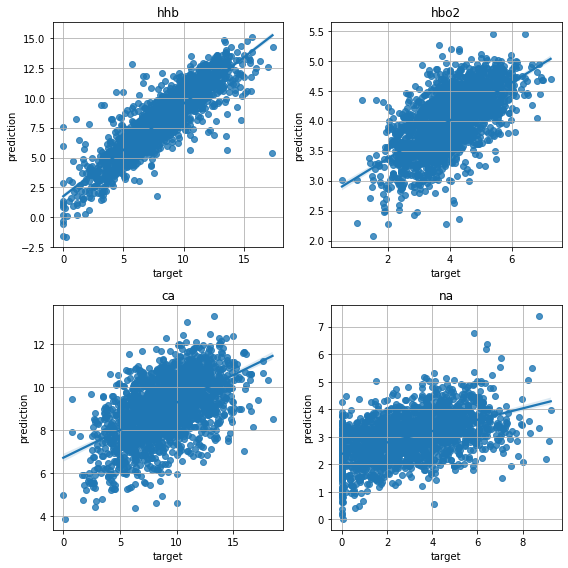

In [34]:
plt.figure(figsize=(8,8))
for i, col in enumerate(y_test.columns):
    plt.subplot(2,2,i+1)
    #plt.scatter(y_test[col], y_pred[col])
    sns.regplot(x=y_test[col], y=y_pred[col])
    plt.title(col)
    plt.xlabel('target')
    plt.ylabel('prediction')
    plt.grid()
plt.tight_layout()

In [35]:
# submit
y_submits = list()
y_submits.append(list(range(10000, 20000)))
for label in y_train.columns:
    print(label)
    result = models[label].predict(x_submit_selected[label])
    y_submits.append(result)
y_submit = pd.DataFrame(y_submits, index=['id']+list(y_train_sample.columns)).T
y_submit = y_submit.astype({'id': int})
y_submit

hhb
hbo2
ca
na


,id,hhb,hbo2,ca,na
0,10000,7.957630,4.541558,7.415456,3.424835
1,10001,7.791924,2.321708,8.879439,3.163667
2,10002,8.720035,4.426838,10.219403,3.519845
3,10003,8.035261,4.281315,8.490603,4.100101
4,10004,6.533651,3.083352,9.109955,3.589460
...,...,...,...,...,...
9995,19995,4.274907,3.974350,9.945929,3.478923
9996,19996,10.200964,3.621480,8.533264,2.177030
9997,19997,7.226486,4.161887,8.408121,3.557338
9998,19998,12.274776,4.186785,10.243980,3.153363


In [36]:
#Save Excel 
#sample_data.to_csv('Dacon_Yeonghwan_20200621_1.csv', index=False)
y_submit.to_csv('Dacon_Yeonghwan_20200621_3.csv', index=False)